In [208]:
import numpy as np
from scipy import optimize
import pandas as pd
import pickle as pk
import tifffile
import matplotlib.pyplot as plt

In [6]:
cd ~/PycharmProjects/IMyG/

/Users/rubinlab_imaging/PycharmProjects/IMyG


In [7]:
import IMyG as im

In [502]:
data = pk.load(open("/Volumes/Sam/MSR8_IDW/plate8_raw_files/07252019_raw_files/output/Well_F11/MSR8_F11_0_sample_0_cells.pk",'rb'))

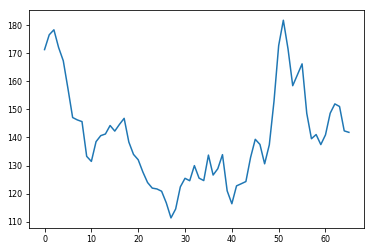

In [167]:
plt.plot(data[19].fl_straighten["FITC"][2])

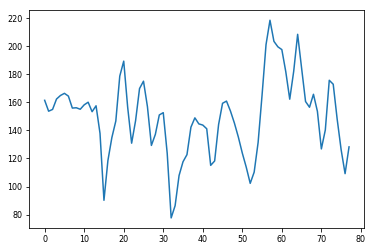

In [168]:
plt.plot(data[19].measure_along_midline["FITC"])

In [78]:
a = data[19].fl_straighten["FITC"][2][:m].mean()
b = data[19].fl_straighten["FITC"][2][-m:].mean()

In [73]:
m = int(0.5*len(data[19].measure_along_midline["FITC"])/2)

In [81]:
data[19].plot_advanced(nd)

NameError: name 'nd' is not defined

In [83]:
from sklearn.mixture import gaussian_mixture as gm

In [87]:
a = gm.GaussianMixture(n_components=1)

In [90]:
a.fit(data[19].fl_img["FITC"])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [93]:
labels = a.fit_predict(data[19].fl_img["FITC"])

In [98]:
x = data[19].measure_along_midline["FITC"]

In [102]:
m = np.cumsum(np.insert(x,0,0))

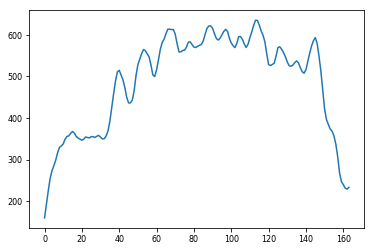

In [106]:
plt.plot((m[5:]-m[:-5])/5)

In [779]:
def moving_window_average(data,window_size = 5):
    if len(data) <= window_size+2:
        raise ValueError("Input array does not have enough values")
    else:
        cum_sum = np.cumsum(np.insert(data,0,0))
        return ((cum_sum[window_size:]-cum_sum[:-window_size])/float(window_size))
    
def symmetry(data,window = 0):
    w = window
    if window == 0:
        w = int(0.5*len(data))
    ratio = data[:w].mean()/data[-w:].mean()
    if ratio > 1:
        ratio = 1/ratio
    return round(ratio,3)

def center_of_mass(data,normalize = True,base = 20):
    min_threshold = np.quantile(data,0.1)
    xcor = np.linspace(0,1,len(data))[data>min_threshold]
    data = data[data>min_threshold]
    if normalize:
        data = (data-data.min()+base)/(data.max()+base)
    center = np.sum((data)*xcor)/np.sum((data))
    return np.round(center,3)

def centrifugality(data):
    half_length = int(0.5*len(data))+1
    first_half = np.flip(data[:half_length])
    second_half = data[-half_length:]
    com_1 = center_of_mass(first_half)
    com_2 = center_of_mass(second_half)
    return round(np.mean([com_1,com_2]),3)

def adjusted_centrifugality(data):
    #find weighted center along cell axis:
    adjusted_center_dist_1 = int(center_of_mass(data)*len(data))
    adjusted_center_dist_2 = len(data) - adjusted_center_dist_1
    first_half = np.flip(data[:adjusted_center_dist_1])
    second_half = data[-adjusted_center_dist_2:]
    com_1 = 2*center_of_mass(first_half)*(adjusted_center_dist_1/len(data))
    com_2 = 2*center_of_mass(second_half)*(adjusted_center_dist_2/len(data))
    return round(np.mean([com_1,com_2]),3)

0.564

(0.372, 0.432)

In [281]:
a,b = adjusted_centrifugality(z)

In [179]:
center_of_mass(np.linspace(1,12,11))*11

7.361538461538462

In [218]:
y = data[99].fl_straighten["FITC"][0]
x = np.linspace(0,1,len(y))
%timeit norm.fit(y,loc=0)

13 µs ± 89 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [209]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

In [316]:
x = np.linspace(0,1,len(b))
popt, _ = optimize.curve_fit(gaussian, x, b)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [314]:
popt[1]

0.14705339822919042

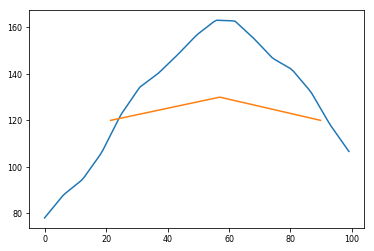

In [875]:
data1 = pk.load(open("/Volumes/Sam/MSR8_IDW/plate8_raw_files/07252019_raw_files/output/Well_A08/MSR8_A08_1_sample_1_cells.pk",'rb'))
outlist1 = []
for i in range(len(data1)):
    y = data1[i].fl_straighten["FITC"][0]
    x = np.linspace(0,1,len(y))
    z_interpolated = interpolate.interp1d(x,y)
    m = z_interpolated(np.linspace(0,1,100))
    m_smoothed = moving_window_average(m)
    a = center_of_mass(m_smoothed)
    #b,c = adjusted_centrifugality(m)
    d = adjusted_centrifugality(m_smoothed)
    outlist1.append(d)

(array([ 6., 13., 25., 18., 25., 21.,  9.,  3.,  2.,  3.]),
 array([0.281 , 0.3192, 0.3574, 0.3956, 0.4338, 0.472 , 0.5102, 0.5484,
        0.5866, 0.6248, 0.663 ]),
 <a list of 10 Patch objects>)

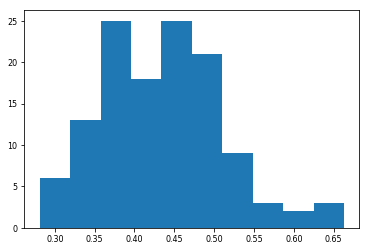

In [876]:
plt.hist(outlist1)

In [879]:
data2 = pk.load(open("/Volumes/Sam/MSR8_IDW/plate8_raw_files/07252019_raw_files/output/Well_A01/MSR8_A01_0_sample_0_cells.pk",'rb'))
outlist2 = []
for i in range(len(data2)):
    y = data2[i].measure_along_midline["FITC"]
    x = np.linspace(0,1,len(y))
    z_interpolated = interpolate.interp1d(x,y)
    m = z_interpolated(np.linspace(0,1,100))
    m_smoothed = moving_window_average(m)
    a = center_of_mass(m_smoothed)
    #b,c = adjusted_centrifugality(m)
    #d = centrifugality(m_smoothed)
    d = adjusted_centrifugality(m_smoothed)
    outlist2.append(d)

(array([ 6., 13., 25., 18., 25., 21.,  9.,  3.,  2.,  3.]),
 array([0.281 , 0.3192, 0.3574, 0.3956, 0.4338, 0.472 , 0.5102, 0.5484,
        0.5866, 0.6248, 0.663 ]),
 <a list of 10 Patch objects>)

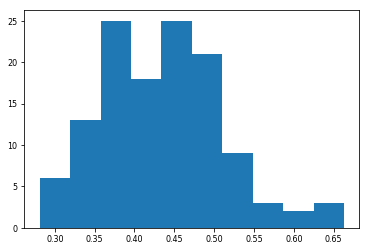

In [880]:
plt.hist(outlist1)

In [881]:
np.mean(outlist2)

0.44562295081967207

In [657]:
len(data2)

459

In [643]:
SNR = []
for cell in data2:
    if cell.SNR["FITC"] >3:
        SNR.append(cell.SNR["FITC"])

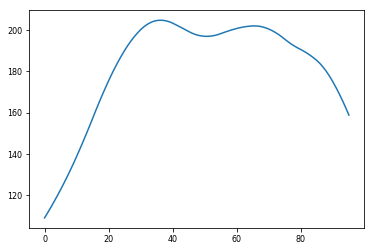

In [737]:
y = data2[19].fl_straighten["FITC"][0]
x = np.linspace(0,1,len(y))
z_interpolated = interpolate.interp1d(x,y)
m = z_interpolated(np.linspace(0,1,100))
m_smoothed = moving_window_average(m)
plt.plot(m_smoothed)

In [799]:
min_center = 1-center_of_mass(np.linspace(0,1,100))
max_center = 1-a